In [1]:
from __future__ import print_function, division

import os
import operator
import functools
import time
import glob
import tables as tb
import pandas as pd
print("Running on ", time.asctime())

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import invisible_cities.database.load_db as DB
import invisible_cities.core.system_of_units_c as SystemOfUnits
import invisible_cities.reco.pmaps_functions as pmapf
import invisible_cities.core.fit_functions as fitf

DataPMT = DB.DataPMT()
DataSiPM = DB.DataSiPM()
units = SystemOfUnits.SystemOfUnits()
pi = np.pi


Running on  Tue Apr 18 19:19:53 2017


#### General plotting options

In [2]:
plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

outputfolder = "plots/Na_3614/Cuts_S1h_S1w_S2i"
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

#### Usefull functions

In [3]:
def width(times, to_mus=False):
    """
    Compute peak width.
    """
    w = (np.max(times) - np.min(times)) if np.any(times) else 0.
    return w * units.ns/units.mus if to_mus else w


def timefunc(f):
    """
    Decorator for function timing.
    """
    def time_f(*args, **kwargs):
        t0 = time.time()
        output = f(*args, **kwargs)
        print("Time spent in {}: {} s".format(f.__name__,
                                              time.time() - t0))
        return output
    return time_f


def integrate_charge(d):
    """
    Integrate charge from a SiPM dictionary.
    """
    newd = dict((key, np.sum(value)) for key, value in d.items())
    return map(np.array, list(zip(*newd.items())))


def flat(nested_list):
    while hasattr(nested_list[0], "__iter__"):
        nested_list = [item for inner_list in nested_list for item in inner_list]
    return np.array(nested_list)


def labels(xlabel, ylabel):
    """
    Set x and y labels.
    """
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


def hist(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist(*args, **kwargs)

    
def hist2d(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist2d(*args, **kwargs)

    
def pdf(data, *args, **kwargs):
    """
    Create a normalized histogram with appropiate range.
    """
    data = np.array(data)
    h = hist(data, *args, **kwargs, weights=np.ones_like(data)/len(data))
    plt.yscale("log")
    plt.ylim(1e-4, 1.)
    return h
    
def scatter(*args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    return plt.scatter(*args, **kwargs)


def save_to_folder(outputfolder, name):
    """
    Set title and save plot in folder.
    """
    plt.title(name)
    plt.savefig("{}/{}.png".format(outputfolder, name), dpi=100)



def get_centers(xbins):
    # xbins should be shifted, as it contains the lower bounds
    # and we want bin centers
    return xbins[:-1] + np.diff(xbins) * 0.5


def profile_and_scatter(x, y, z, nbin, *args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    x, y, z, ze = fitf.profileXY(x, y, z, *nbin, *args, **kwargs)
    x_ = np.repeat(x, x.size)
    y_ = np.tile  (y, y.size)
    z_ = z.flatten()
    return (x, y, z, ze), plt.scatter(x_, y_, c=z_, marker="s"), plt.colorbar()

save = functools.partial(save_to_folder, outputfolder)

### Input data

In [4]:
# Comment out this line if your data is in $IC_DATA
os.environ["IC_DATA"] = "/home/brais/Documents/Next/Na/data/3614_DST/"

pattern = "$IC_DATA/run*.dst"
ifiles  = glob.glob(os.path.expandvars(pattern))
print("# files:", len(ifiles))

# files: 1


### Reading data

In [5]:
def load_dst(filename, group, node):
    with tb.open_file(filename) as h5in:
        table = getattr(getattr(h5in.root, group), node).read()
        return pd.DataFrame.from_records(table)

In [6]:
data_read = load_dst(ifiles[0], "DST", "Events")

In [7]:
data_read

,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,1,1.491674e+09,0,1,275.0,49.620018,287.162550,537150.0,40.100437,13367.398438,...,657112.5,54,119.9625,119.9625,97.811136,40.847802,105.997930,0.395602,25.243436,11.175782
1,2,1.491674e+09,0,1,200.0,24.205078,129.749825,557000.0,38.343750,10287.787109,...,653687.5,25,96.6875,96.6875,136.927309,5.200002,137.026012,0.037958,9.209800,10.444016
2,4,1.491674e+09,0,1,225.0,30.098822,160.997304,470600.0,23.514125,8284.446289,...,664512.5,19,193.9125,193.9125,-55.612291,-10.052078,56.513460,-2.962771,10.149977,8.824298
3,5,1.491674e+09,0,2,225.0,54.494896,286.139376,615225.0,45.152500,10520.092773,...,672387.5,54,57.1625,57.1625,-21.676225,165.445635,166.859572,1.701072,15.885687,18.841620
4,5,1.491674e+09,1,2,225.0,54.494896,286.139376,615225.0,29.291875,6783.470215,...,918112.5,26,302.8875,302.8875,-168.863477,45.446878,174.872218,2.878688,9.241491,15.903105
5,8,1.491674e+09,0,1,325.0,31.736614,165.305724,636875.0,31.787500,34261.953125,...,661412.5,47,24.5375,24.5375,-15.939325,-11.792324,19.827279,-2.504635,21.752563,23.834757
6,9,1.491674e+09,0,1,225.0,26.748526,159.692408,489400.0,23.693750,8325.739258,...,657437.5,25,168.0375,168.0375,93.885652,22.494355,96.542797,0.235160,10.005769,11.830000
7,10,1.491674e+09,0,1,250.0,52.593689,285.323524,474350.0,36.056375,12732.656250,...,657812.5,49,183.4625,183.4625,-138.239810,12.774642,138.828803,3.049445,19.149601,13.415596
8,11,1.491674e+09,0,1,250.0,13.720692,90.543010,590350.0,19.764563,7944.929199,...,666012.5,20,75.6625,75.6625,-63.069691,-2.985949,63.140335,-3.094284,8.536955,8.548020
9,12,1.491674e+09,0,1,175.0,13.480074,72.238658,559650.0,13.106063,13720.609375,...,655787.5,29,96.1375,96.1375,-97.459859,-13.289184,98.361713,-3.006073,10.916775,10.313899



### Filtering data

In [366]:
from copy import deepcopy
from functools import reduce

def Filter(data):
    filtered_XR = deepcopy(data)
    filtered_noXR = deepcopy(data)
    
    min_S1w = 250.
    max_S1w = 400.
    min_S1h = 10.
    max_S1h = 100.
    
    min_S2e = 1000.
    max_S2e = 12000.
    
    print('Inicial: ',len(filtered_XR), len(filtered_noXR))

    filtered_XR = filtered_XR[filtered_XR.nS2>1]
    print('nS2 > 1: ', len(filtered_XR))
    
    filtered_XR = filtered_XR[filtered_XR.S2e>min_S2e]
    filtered_XR = filtered_XR[filtered_XR.S2e<max_S2e]
    
    
    print('S2 XR Energy: ', len(filtered_XR))
    
    filtered_XR = filtered_XR[filtered_XR.Nsipm>0]
    
    print('Nsimp > 0: ', len(filtered_XR))
    

    
    
    #filtered_noXR = filtered_noXR[filtered_noXR.S2e<min_S2e]
    filtered_noXR = filtered_noXR[filtered_noXR.S2e>max_S2e]
    
    print('no XR: ', len(filtered_noXR))
    
    return filtered_XR, filtered_noXR


In [367]:
filt_XR, filt_noXR = Filter(data_read)

Inicial:  363085 363085
nS2 > 1:  89778
S2 XR Energy:  27890
Nsimp > 0:  27890
no XR:  335195


### S1 and S2 propierties

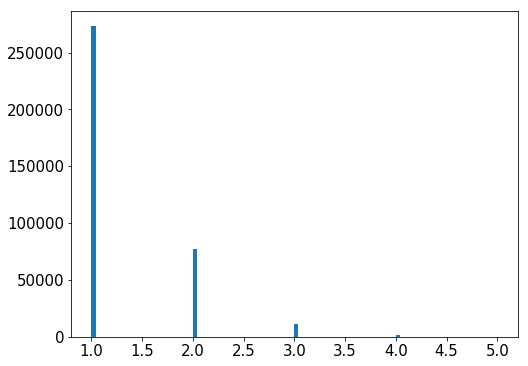

In [377]:
hist(full.nS2,100);

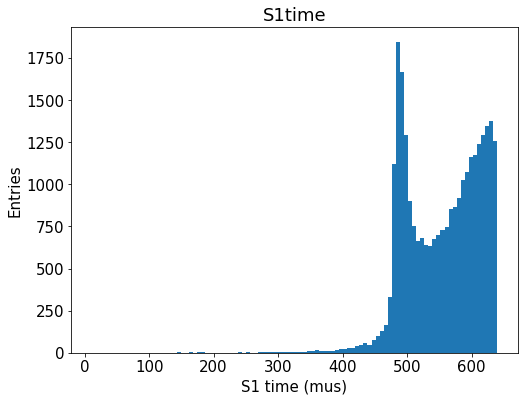

In [10]:
s1t = filt_XR.S1t/1e3

hist(s1t, 100)
labels("S1 time (mus)", "Entries")
save("S1time")

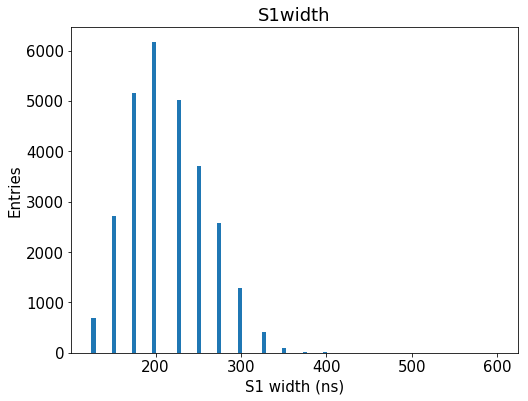

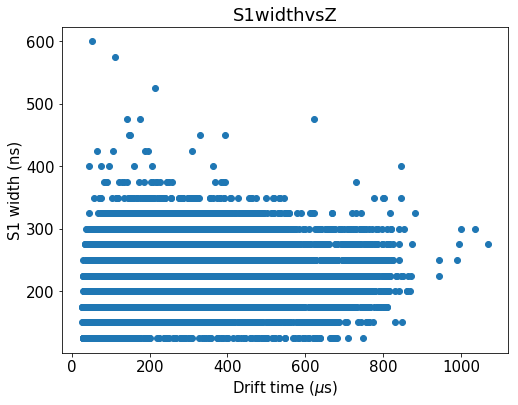

In [11]:
s1w = filt_XR.S1w

################################
hist(s1w, 100)#, range=(0, 900))
labels("S1 width (ns)", "Entries")
save("S1width")

################################

scatter(filt_XR.Z, s1w)
#x, y, _ = fitf.profileX(filt_XR.Z, s1w, 50)
#plt.plot(x, y, profOpt)
#f = fitf.fit(fitf.polynom, x, y, (1., 1.))
#plt.plot(x, f.fn(x), fitOpt)
#plt.text(20, 20, "{:.3f} + {:.3f} x".format(*f.values))
labels("Drift time ($\mu$s)", "S1 width (ns)")

save("S1widthvsZ")

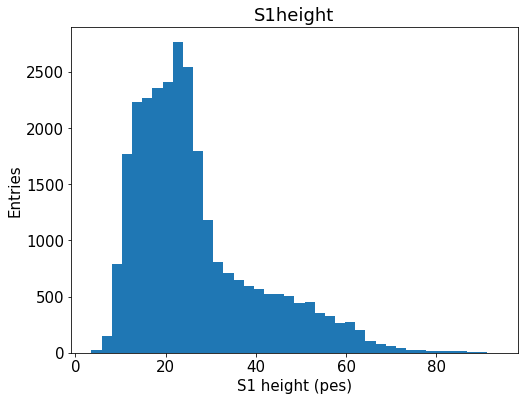

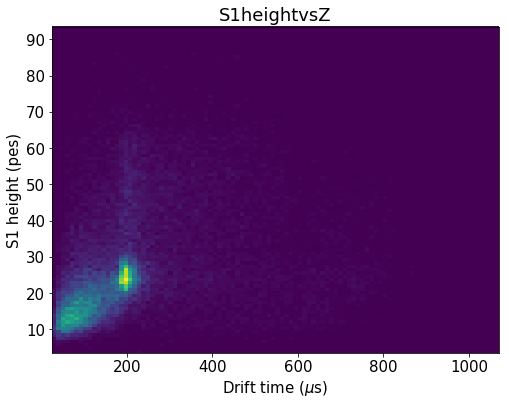

In [296]:
s1h = filt_XR.S1h


################################
hist(s1h, 40)
#plt.semilogy()
labels("S1 height (pes)", "Entries")
save("S1height")

################################

hist2d(filt_XR.Z, s1h,[100,100])
#x, y, _ = fitf.profileX(data.Z[:,0], s1h, 100)
#plt.plot(x, y, profOpt)
#f = fitf.fit(fitf.polynom, x, y, (1., 0.8, 0.01))
#plt.plot(x, f.fn(x), fitOpt)
#plt.text(0, 6, "{:.3g} + {:.3g} x + {:.3g} x^2".format(*f.values))
labels("Drift time ($\mu$s)", "S1 height (pes)")
#plt.ylim(0, 100)
save("S1heightvsZ")


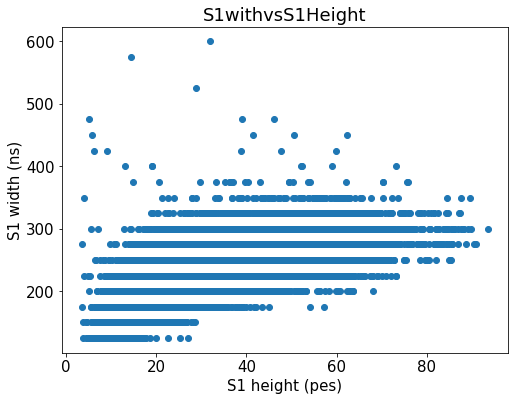

In [13]:
s1h = filt_XR.S1h
s1w = filt_XR.S1w

scatter(s1h,s1w)
plt.yscale
#x, y, _ = fitf.profileX(s1h, s1w, 100)
#plt.plot(x, y, profOpt)
#f = fitf.fit(fitf.polynom, x, y, (1., 1e-2, 1e-4))
#plt.plot(x, f.fn(x), fitOpt)
#plt.text(0, 100, "{:.3g} + {:.3g} x + {:.3g} x^2".format(*f.values))
labels("S1 height (pes)", "S1 width (ns)")
#plt.xlim(0, 100)
save("S1withvsS1Height")

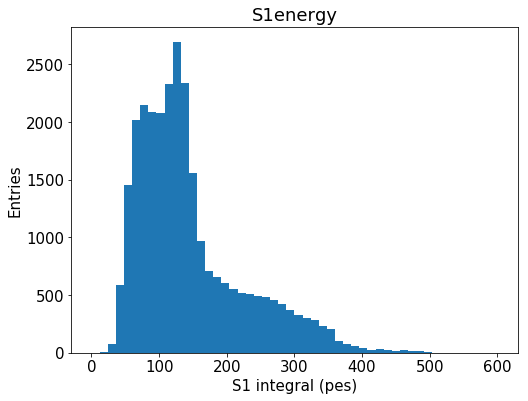

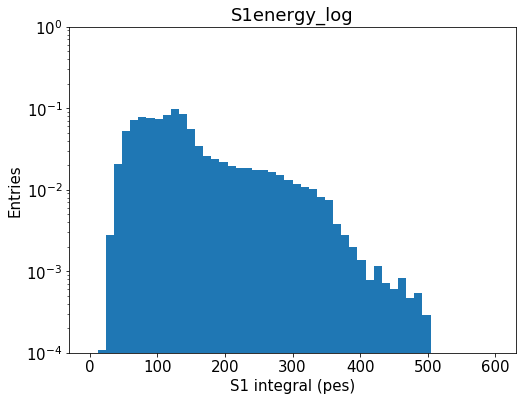

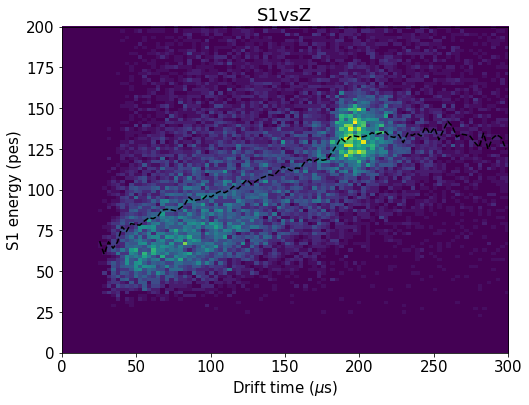

In [295]:
s1e = filt_XR.S1e

################################
hist(s1e, 50, range=(0, 600))
labels("S1 integral (pes)", "Entries")
save("S1energy")

################################
pdf(s1e, 50, range=(0, 600))
labels("S1 integral (pes)", "Entries")
save("S1energy_log")

################################

hist2d(filt_XR.Z, s1e,[100,100],range=([[0,300],[0,200]]))
x, y, _ = fitf.profileX(filt_XR.Z, s1e, 100, xrange=[0,300],yrange=[0,200])
plt.plot(x, y, profOpt)
labels("Drift time ($\mu$s)", "S1 energy (pes)")

save("S1vsZ")


/home/brais/Documents/Next/IC/IC-1/invisible_cities/core/fit_functions.py:123: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum(np.ma.masked_invalid((fitx - y)**2/y))


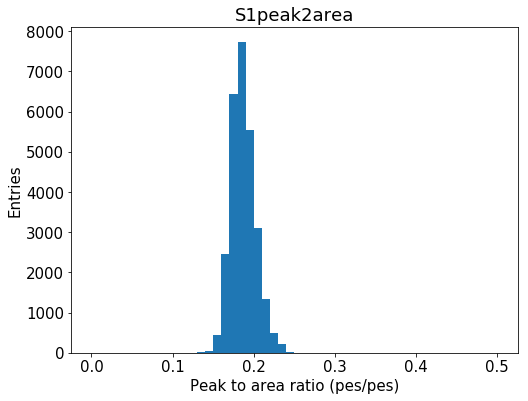

In [15]:
################################
y, x, _ = hist(s1h/s1e, 50, range=(0, 0.5))
x = x[:-1] + np.diff(x) * 0.5
f = fitf.fit(fitf.gauss, x, y, (1e5, 0.3, 0.01))
#plt.plot(x, f.fn(x), "r")
labels("Peak to area ratio (pes/pes)", "Entries")
save("S1peak2area")

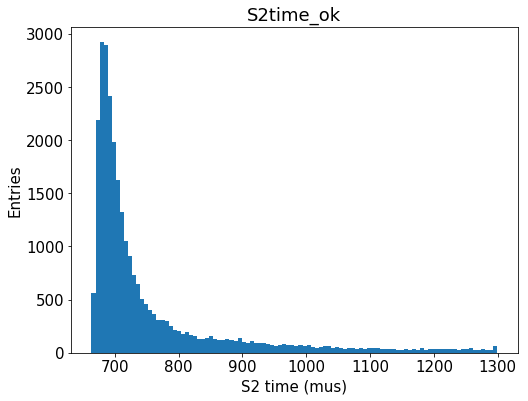

In [16]:
s2t =filt_XR.S2t/1e3

################################
hist(s2t, 100)#, range=(0, 10e2))
labels("S2 time (mus)", "Entries")
save("S2time_ok")

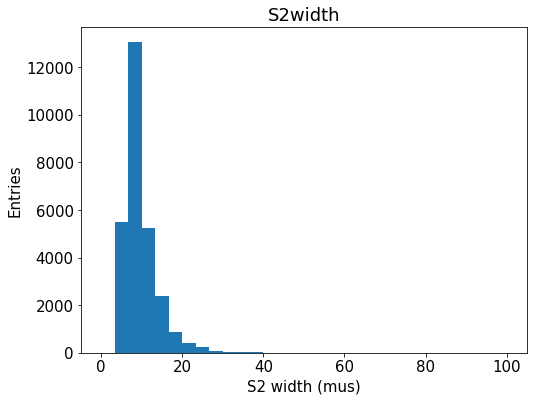

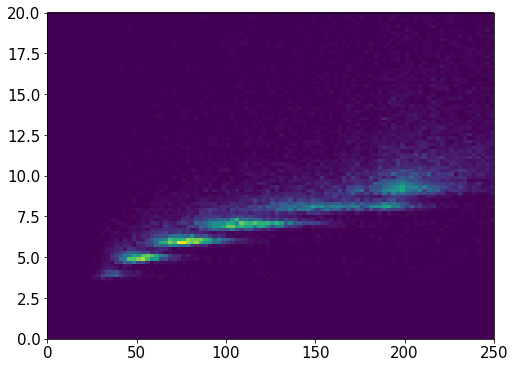

In [300]:
s2w = filt_XR.S2w

################################
hist(s2w, 30, range=(0, 100))
labels("S2 width (mus)", "Entries")
save("S2width")

################################
hist2d(filt_XR.Z, s2w,[100,100],range=[[0,250],[0,20]]);
#x, y, _ = fitf.profileX(data.Z, s2w, 100)
#plt.plot(x, y, profOpt)
#f = fitf.fit(fitf.power, x, y, (1., 0.8))
#plt.plot(x, f.fn(x), fitOpt)
#plt.text(0, 20, "{:.3f} $\cdot$ x^{:.2f}".format(*f.values))
#labels("Drift time ($\mu$s)", "S2 width ($\mu$s)")
#plt.ylim(0, 30)
#save("S2widthvsZ")

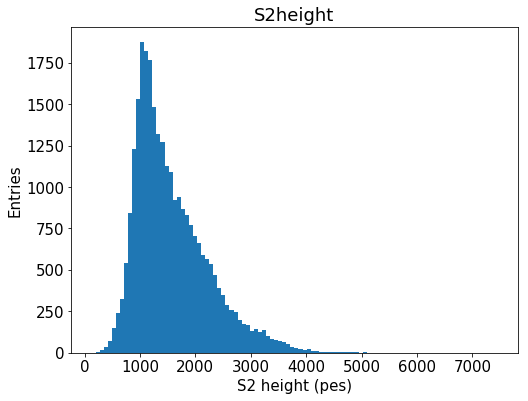

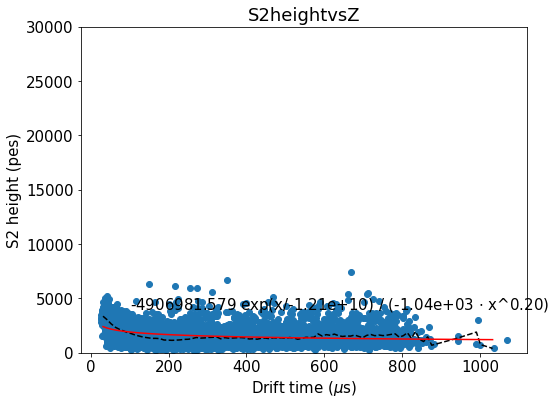

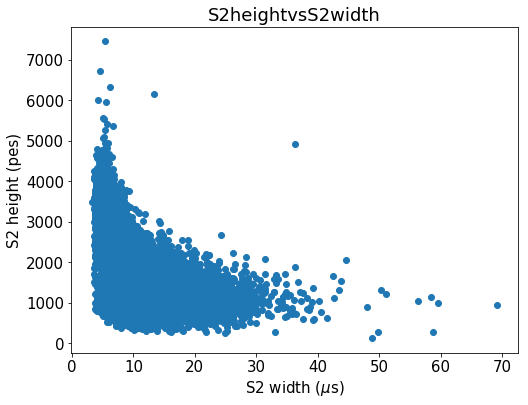

In [18]:
s2h = filt_XR.S2h

################################
hist(s2h, 100)#, range=(0, 15e3))
labels("S2 height (pes)", "Entries")
save("S2height")

################################
scatter(filt_XR.Z, s2h)
x, y, _ = fitf.profileX(filt_XR.Z, s2h, 100)
plt.plot(x, y, profOpt)
fun = lambda x, *args: fitf.expo(x,*args[:2])/fitf.power(x, *args[2:])
f = fitf.fit(fun, x, y, (1., -2e4, 0.1, -0.8))
plt.plot(x, f.fn(x), fitOpt)
plt.text(1e2, 4e3, "{:.3f} exp(x/{:.3g}) / "
                   "({:.3g} $\cdot$ x^{:.2f})".format(*f.values))
labels("Drift time ($\mu$s)", "S2 height (pes)")
plt.ylim(0, 3e4)
save("S2heightvsZ")

################################
scatter(s2w, s2h)
#x, y, _ = fitf.profileX(s2w, s2h, 50)
#plt.plot(x, y, profOpt)
#f = fitf.fit(fitf.power, x, y, (1., -1.0))
#plt.plot(x, f.fn(x), fitOpt)
#plt.text(10, 4e3, "{:.3f} $\cdot$ x^{:.2f}".format(*f.values))
labels("S2 width ($\mu$s)", "S2 height (pes)")
#plt.ylim(0, 3e4)
#plt.xlim(0,100)
save("S2heightvsS2width")

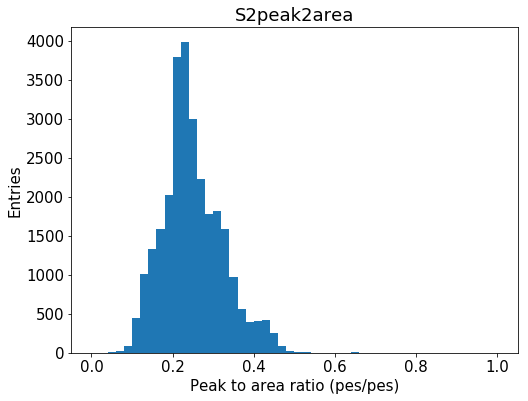

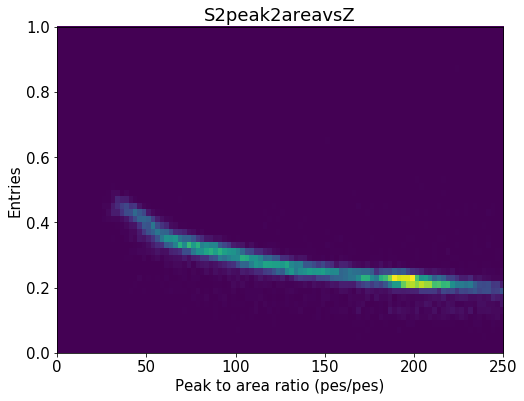

In [301]:
################################
s2e= filt_XR.S2e
hist(s2h/s2e, 50, range=(0, 1))
labels("Peak to area ratio (pes/pes)", "Entries")
save("S2peak2area")

################################
s2e= filt_XR.S2e
hist2d(filt_XR.Z, s2h/s2e, [100,50], range=([[0,250],[0, 1]]))
labels("Peak to area ratio (pes/pes)", "Entries")
save("S2peak2areavsZ")

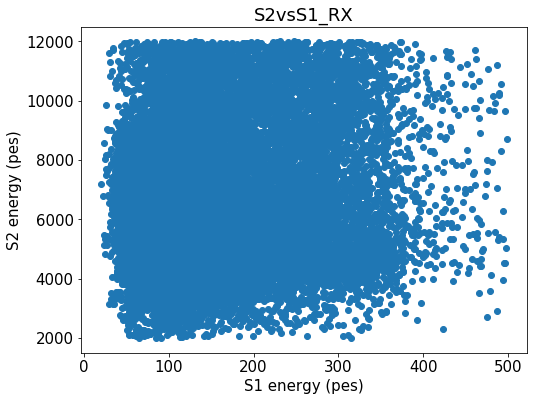

In [20]:
################################
scatter(s1e, s2e)

labels("S1 energy (pes)", "S2 energy (pes)")
save("S2vsS1_RX")

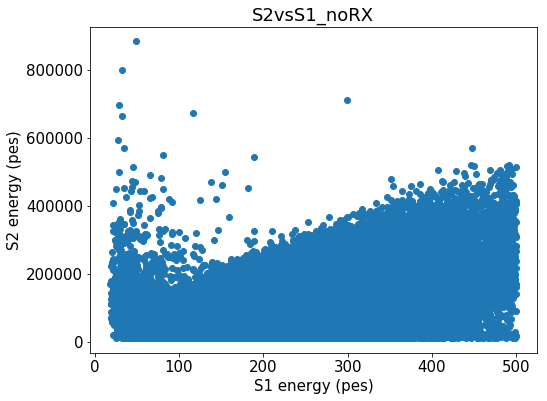

In [51]:
################################
scatter(filt_noXR.S1e, filt_noXR.S2e)

labels("S1 energy (pes)", "S2 energy (pes)")
save("S2vsS1_noRX")

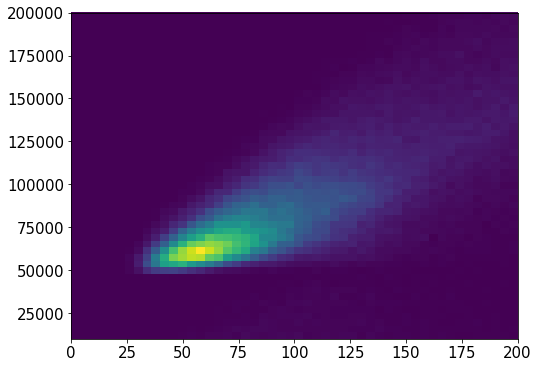

In [374]:
hist2d(full[full.Z<150].S1e, full[full.Z<150].S2e,[50,50],range=([[0,200],[1e4,20e4]]));

### Energy

In [23]:
s2e = filt_XR.S2e

In [24]:
(2.355*1272/4670.),(30/2458)**0.5*(2.355*1272/4670)

(0.6414475374732334, 0.07086484316436774)

In [379]:
fun = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:-1])+args[-1] 

/home/brais/Documents/Next/IC/IC-1/invisible_cities/core/fit_functions.py:123: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum(np.ma.masked_invalid((fitx - y)**2/y))


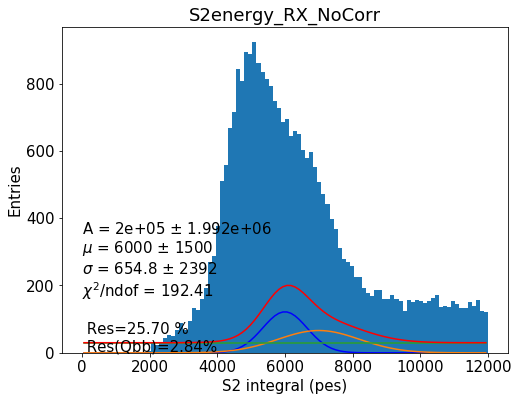

In [25]:


s2e = filt_XR.S2e
entries, xbins, _ = hist(s2e, 100, range=(0, 12e3))
xbins = get_centers(xbins)


f = fitf.fit(fun, xbins, entries,( 9e4, 6500, 500, 9e4, 7050, 500, 10),
                                            bounds=([8e4, 6000, 100, 1e4, 7000, 500, 0],
                                                    [2e5, 7000, 1000,2e5, 7500, 2e4, 30]))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
text = "\n".join(["{} = {:.4g} $\pm$ {:.4g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (30/2458)**0.5*res*100)

plt.text(0, 5, text, fontsize=15);
plt.plot(xbins, fitf.gauss(xbins, *f.values[:3]), "b-")
plt.plot(xbins, fitf.gauss(xbins, *f.values[3:-1]))
plt.plot(xbins, f.values[-1]*np.ones_like(xbins))
plt.plot(xbins, f.fn(xbins), fitOpt)


labels("S2 integral (pes)", "Entries")
save("S2energy_RX_NoCorr")

# Z Correction 

FitFunction(fn=<function fit.<locals>.<lambda> at 0x7fa003168840>, values=array([ 8225.23691871,  -358.16376047]), errors=array([ 46.7470656 ,   7.32147718]), chi2=0.68621723489006925)


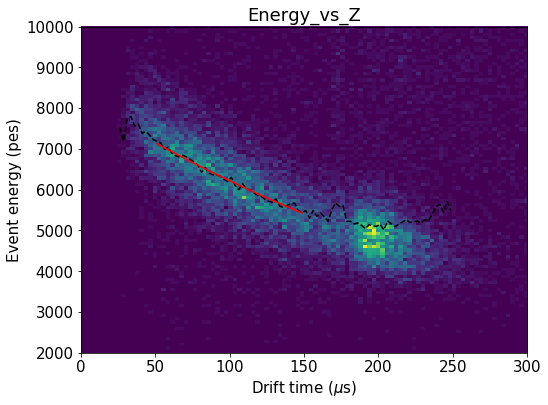

In [283]:
rcut = 175.

xbin, ybin, z, axis = hist2d(filt_XR[filt_XR.R<rcut].Z, filt_XR[filt_XR.R<rcut].S2e, 100, [[0,300], [2000,10000]])
x, y, _ = fitf.profileX(filt_XR.Z[filt_XR.R<rcut], filt_XR.S2e[filt_XR.R<rcut], 100, xrange=[0,250], yrange=[2000,10000])
plt.plot(x, y, profOpt)
sel  = fitf.in_range(x, 50, 150)
x, y = x[sel], y[sel]
f = fitf.fit(fitf.expo, x, y, (1e5, -200))
plt.plot(x, f.fn(x), fitOpt)
print(f)
labels("Drift time ($\mu$s)", "Event energy (pes)")
save("Energy_vs_Z")

#zfun  = f.fn
#zmin  = np.min(x)
#zcorr = lambda z: zfun(zmin)/zfun(z)

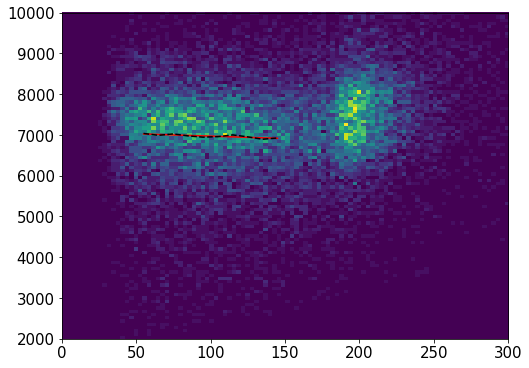

In [27]:
s2e = filt_XR.S2e * zcorr(filt_XR.Z)

xbin, ybin, z, axis = hist2d(filt_XR.Z, s2e, 100, [[0,300], [2000,10000]])
x, y, _ = fitf.profileX(filt_XR.Z, s2e, 30, xrange=[0,300], yrange=[2000,10000])
sel  = fitf.in_range(x, 50, 150)
x, y = x[sel], y[sel]
f = fitf.fit(fitf.expo, x, y, (1e5, -200))
plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, y, profOpt)




[  2.13777512e+06   7.20937586e+03   6.64917946e+02   9.10805455e+04
   8.90256560e+03   5.00000000e+02   2.87368858e+01]
res 0.217200738862 0.0239955653354


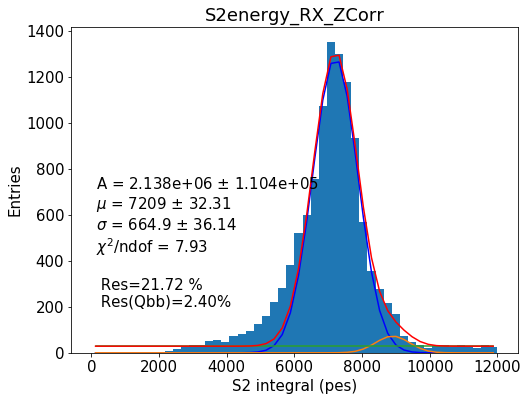

In [28]:
#Antes de Z=150

entries, xbins, _ = hist(s2e[filt_XR.Z<150], 50, range=(0e3, 12e3))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 6000, 12000)


f = fitf.fit(fun, xbins[selbins], entries[selbins],( 9e4, 6500, 500, 9e4, 7050, 500, 10),
                                            bounds=([8e4, 6000, 100, 1e4, 7000, 500, 0],
                                                    [10e6, 9000, 1000,10e5, 9000, 2e4, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(30/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.4g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (30/2458)**0.5*res*100)

plt.text(min(xbins), 200, text, fontsize=15);
plt.plot(xbins, fitf.gauss(xbins, *f.values[:3]), "b-")
plt.plot(xbins, fitf.gauss(xbins, *f.values[3:-1]))
plt.plot(xbins, f.values[-1]*np.ones_like(xbins))
plt.plot(xbins, f.fn(xbins), fitOpt)


labels("S2 integral (pes)", "Entries")
save("S2energy_RX_ZCorr")

[  1.26965567e+06   7.48051980e+03   8.02993642e+02   2.63080979e+04
   9.56813064e+03   5.00000000e+02   7.20808193e+01]
res 0.252796607437 0.0279280703283


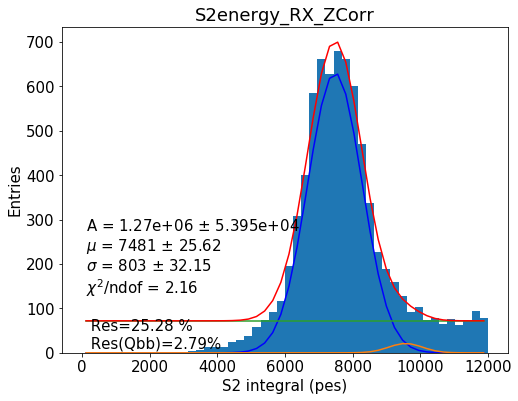

In [29]:
entries, xbins, _ = hist(s2e[filt_XR.Z>175], 50, range=(0e3, 12e3))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 6000, 12000)


f = fitf.fit(fun, xbins[selbins], entries[selbins],( 9e4, 8000, 500, 9e4, 8550, 500, 10),
                                            bounds=([8e4, 6000, 100, 1e4, 8000, 500, 0],
                                                    [10e6, 9000, 1000,10e5, 10000, 2000, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(30/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.4g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (30/2458)**0.5*res*100)

plt.text(min(xbins), 10, text, fontsize=15);
plt.plot(xbins, fitf.gauss(xbins, *f.values[:3]), "b-")
plt.plot(xbins, fitf.gauss(xbins, *f.values[3:-1]))
plt.plot(xbins, f.values[-1]*np.ones_like(xbins))
plt.plot(xbins, f.fn(xbins), fitOpt)


labels("S2 integral (pes)", "Entries")
save("S2energy_RX_ZCorr")

## R correction

[  6.87420678e+03   2.07402613e+01  -1.42126338e-01]


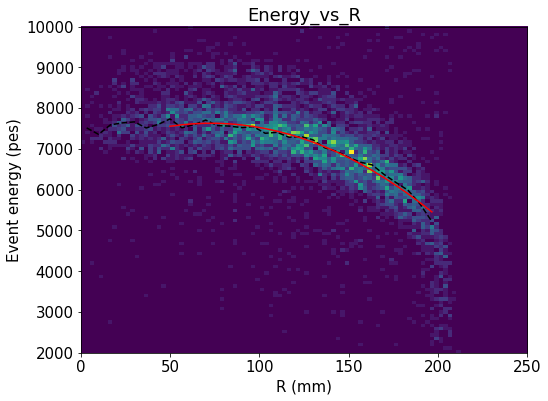

In [30]:
xbin, ybin, z, axis = hist2d(filt_XR[filt_XR.Z<100].R, s2e[filt_XR.Z<100], 100, [[0,250], [2000,10000]])
x, y, _ = fitf.profileX(filt_XR[filt_XR.Z<150].R, s2e[filt_XR.Z<150], 30, xrange=[0,200], yrange=[3000,10000])
plt.plot(x, y, profOpt)
sel  = fitf.in_range(x, 50, 200)
x, y = x[sel], y[sel]
f = fitf.fit(fitf.polynom, x, y, (6000,-200, -200))
plt.plot(x, f.fn(x), fitOpt)
print(f.values)
labels("R (mm)", "Event energy (pes)")
save("Energy_vs_R")

rfun  = f.fn
rmin  = np.min(x)
rcorr = lambda r: rfun(rmin)/rfun(r)

[  1.33952692e+06   7.52411634e+03   4.99743282e+02   1.16485479e+05
   8.85632780e+03   2.45254222e+02   1.51898366e+01]
res 0.156416431644 0.0172803312028


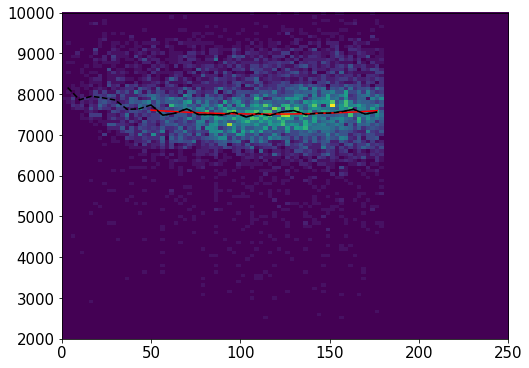

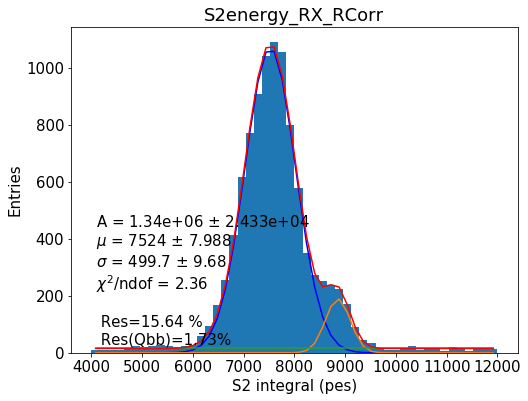

In [145]:
r_s2e = s2e[(filt_XR.Z<150)&(filt_XR.R<180)] * rcorr(filt_XR[(filt_XR.Z<150)&(filt_XR.R<180)].R)

xbin, ybin, z, axis = hist2d(filt_XR[(filt_XR.Z<150)&(filt_XR.R<180)].R, r_s2e, 100, [[0,250], [2000,10000]])
x, y, _ = fitf.profileX(filt_XR[(filt_XR.Z<150)&(filt_XR.R<180)].R, r_s2e, 30, xrange=[0,200], yrange=[3000,10000])
plt.plot(x, y, profOpt)
sel  = fitf.in_range(x, 50, 200)
x, y = x[sel], y[sel]
f = fitf.fit(fitf.polynom, x, y, (6000,-200, -200))
plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, y, profOpt)


entries, xbins, _ = hist(r_s2e, 50, range=(4e3, 12e3))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 6.5e3, 12e3)


f = fitf.fit(fun, xbins[selbins], entries[selbins],( 10e4, 7000, 500, 9e4, 8550, 500, 10),
                                            bounds=([8e4, 6000, 100, 1e4, 8500, 100, 0],
                                                    [10e6, 8000, 1000,15e5, 10000, 2000, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(30/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.4g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (30/2458)**0.5*res*100)

plt.text(min(xbins), 30, text, fontsize=15);
plt.plot(xbins, fitf.gauss(xbins, *f.values[:3]), "b-")
plt.plot(xbins, fitf.gauss(xbins, *f.values[3:-1]))
plt.plot(xbins, f.values[-1]*np.ones_like(xbins))
plt.plot(xbins, f.fn(xbins), fitOpt)


labels("S2 integral (pes)", "Entries")
save("S2energy_RX_RCorr")

[  8.07459509e+05   7.72473722e+03   7.64073694e+02   7.57052670e+04
   8.50000000e+03   1.25415981e+03   2.39995816e+01]
res 0.232939127499 0.0257342865515


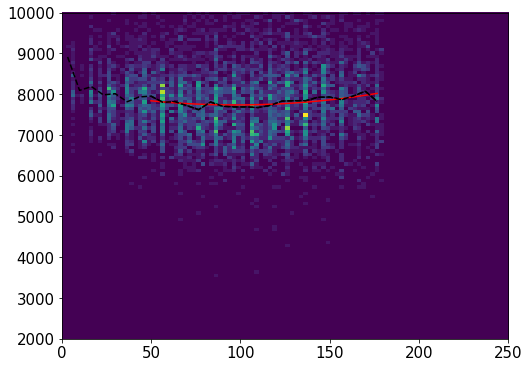

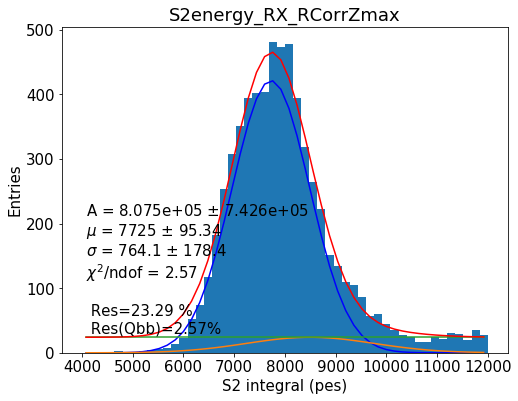

In [63]:
r_s2e_ = s2e[(filt_XR.Z>175)&(filt_XR.R<180)] * rcorr(filt_XR[(filt_XR.Z>175)&(filt_XR.R<180)].R)

xbin, ybin, z, axis = hist2d(filt_XR[(filt_XR.Z>175)&(filt_XR.R<180)].R, r_s2e_, 100, [[0,250], [2000,10000]])
x, y, _ = fitf.profileX(filt_XR[(filt_XR.Z>175)&(filt_XR.R<180)].R, r_s2e_, 30, xrange=[0,200], yrange=[3000,10000])
plt.plot(x, y, profOpt)
sel  = fitf.in_range(x, 50, 200)
x, y = x[sel], y[sel]
f = fitf.fit(fitf.polynom, x, y, (6000,-200, -200))
plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, y, profOpt)


entries, xbins, _ = hist(r_s2e_, 50, range=(4e3, 12e3))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 6.5e3, 12e3)


f = fitf.fit(fun, xbins[selbins], entries[selbins],( 10e4, 7000, 500, 9e4, 8550, 500, 10),
                                            bounds=([8e4, 6000, 100, 1e4, 8500, 100, 0],
                                                    [10e6, 8000, 1000,15e5, 10000, 2000, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(30/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.4g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (30/2458)**0.5*res*100)

plt.text(min(xbins), 30, text, fontsize=15);
plt.plot(xbins, fitf.gauss(xbins, *f.values[:3]), "b-")
plt.plot(xbins, fitf.gauss(xbins, *f.values[3:-1]))
plt.plot(xbins, f.values[-1]*np.ones_like(xbins))
plt.plot(xbins, f.fn(xbins), fitOpt)


labels("S2 integral (pes)", "Entries")
save("S2energy_RX_RCorrZmax")

# Phi

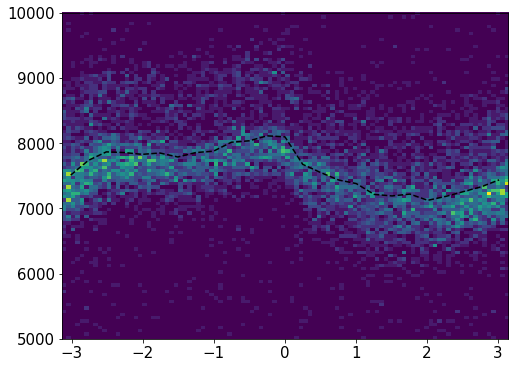

In [136]:
xbin, ybin, z, axis = hist2d(filt_XR[(filt_XR.Z<150)&(filt_XR.R<180)].Phi, r_s2e, 100, [[-pi,pi], [5000,10000]])
x, y, _ = fitf.profileX(filt_XR[(filt_XR.Z<150)&(filt_XR.R<180)].Phi, r_s2e, 25, xrange=[-pi,pi], yrange=[5000,10000])
plt.plot(x, y, profOpt)
def get_phicorr(T, E):
    eref = np.max(E)
    def phicorr(t):
        dt = np.abs(t[:, np.newaxis]-T)
        return eref / E[np.apply_along_axis(np.argmin, 1, dt)]
    return phicorr
phicorr = get_phicorr(x, y) 

[  1.00211504e+06   7.93856863e+03   3.29007763e+02   2.25127470e+05
   9.02171033e+03   3.14192430e+02   2.55635071e+01]
res 0.09760113164 0.0107826259862


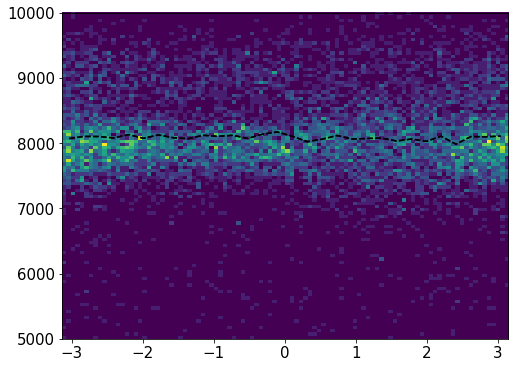

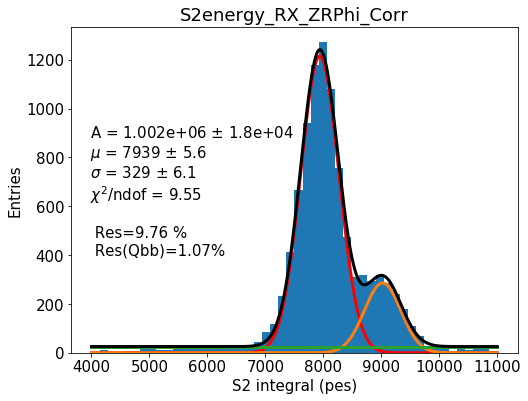

In [200]:
rphi_s2e = r_s2e * phicorr(filt_XR[(filt_XR.Z<150)&(filt_XR.R<180)].Phi)

xbin, ybin, z, axis = hist2d(filt_XR[(filt_XR.Z<150)&(filt_XR.R<180)].Phi, rphi_s2e, 100, [[-pi,+pi], [5000,10000]])
x, y, _ = fitf.profileX(filt_XR[(filt_XR.Z<150)&(filt_XR.R<180)].Phi, rphi_s2e, 30, xrange=[-pi,pi], yrange=[5000,10000])
plt.plot(x, y, profOpt)
#sel  = fitf.in_range(x, 50, 200)
#x, y = x[sel], y[sel]
#f = fitf.fit(fitf.polynom, x, y, (6000,-200, -200))
#plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, y, profOpt)


entries, xbins, _ = hist(rphi_s2e, 50, range=(4e3, 11e3))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 6.5e3, 12e3)


f = fitf.fit(fun, xbins[selbins], entries[selbins],( 10e4, 7000, 500, 9e4, 8550, 500, 10),
                                            bounds=([8e4, 6000, 100, 1e4, 8500, 100, 0],
                                                    [10e6, 8000, 1000,15e5, 10000, 2000, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(30/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (29.6/2458)**0.5*res*100)

xrange = np.linspace(4e3, 11e3,1000)

plt.text(min(xbins)-100, 400, text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=3)
plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]), linewidth=3)
plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=3)
plt.plot(xrange, f.fn(xrange), "k-", linewidth=3)


labels("S2 integral (pes)", "Entries")
save("S2energy_RX_ZRPhi_Corr")

[  3.61449719e+05   7.92257372e+03   3.00344668e+02   1.19930123e+05
   8.93198534e+03   3.93361621e+02   8.11174346e+00]
res 0.0892780198781 0.00986311819297


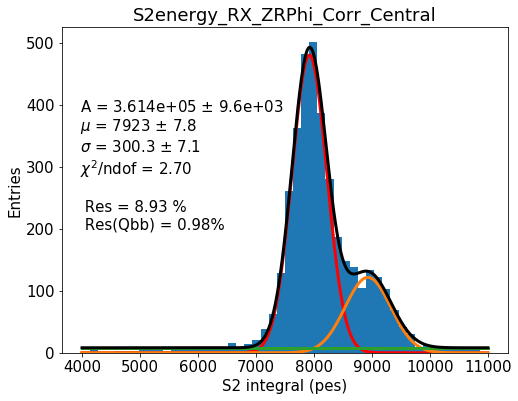

In [204]:
rphi_s2e_c = r_s2e[(filt_XR.Z<150)&(filt_XR.R<100)] * phicorr(filt_XR[(filt_XR.Z<150)&(filt_XR.R<100)].Phi)


entries, xbins, _ = hist(rphi_s2e_c, 50, range=(4e3, 11e3))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 6.5e3, 12e3)


f = fitf.fit(fun, xbins[selbins], entries[selbins],( 10e4, 7000, 500, 9e4, 8550, 500, 10),
                                            bounds=([8e4, 6000, 100, 1e4, 8500, 100, 0],
                                                    [10e6, 8000, 1000,15e5, 10000, 2000, 300] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values)
print('res',res,(30/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("A $\mu$ $\sigma$".split(),
                                            f.values,
                                            f.errors)] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res = {:.2f} % \n Res(Qbb) = {:.2f}% ".format(res*100, (29.6/2458)**0.5*res*100)

xrange = np.linspace(4e3, 11e3,1000)

plt.text(min(xbins)-100, 200, text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=3)
plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]), linewidth=3)
plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=3)
plt.plot(xrange, f.fn(xrange), "k-", linewidth=3)


labels("S2 integral (pes)", "Entries")
save("S2energy_RX_ZRPhi_Corr_Central")

# XY corrections

7268.17754529


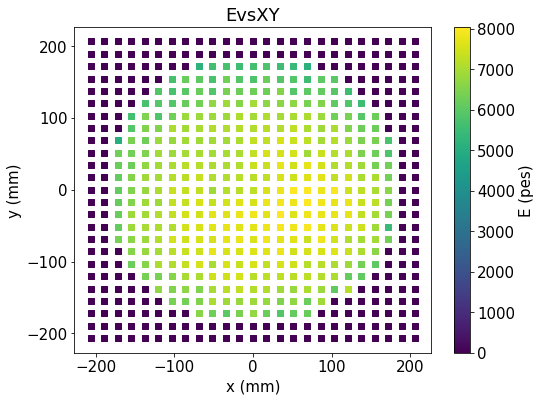

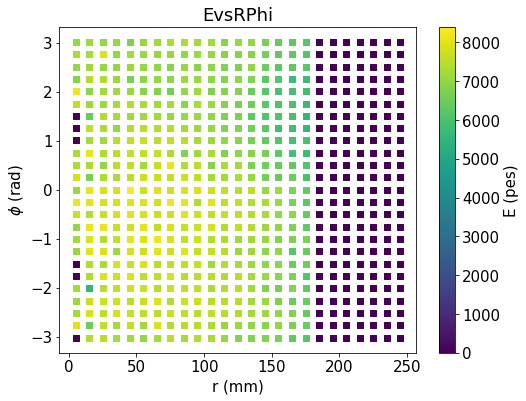

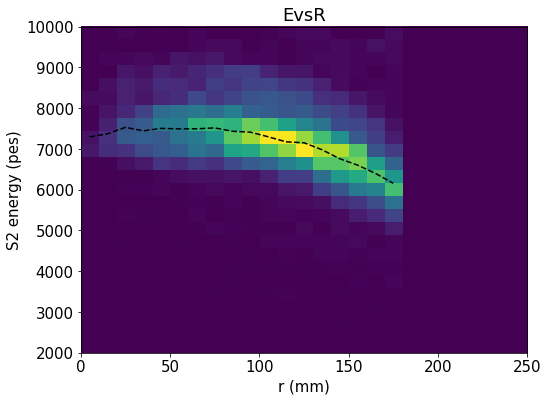

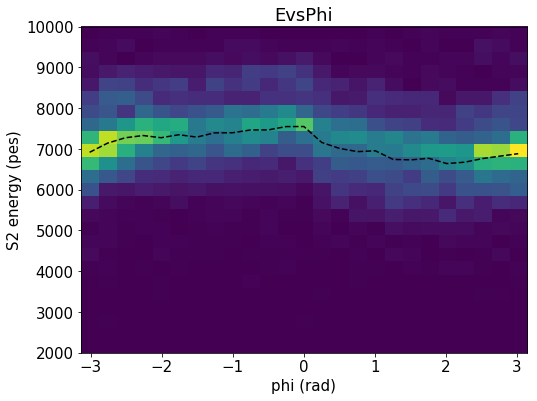

In [431]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 250
prange = - pi,  pi
Erange =  2e3, 10e3
nbin = 25

#data = filt_XR[filt_XR.Z<150][:]
data = filt_XR[(filt_XR.Z<150)&(filt_XR.R<180)][:]
data =  data[data.S2e * zcorr(data.Z)<10e3]
Ez  = data.S2e * zcorr(data.Z)


pf, _, cb = profile_and_scatter(data.X, data.Y, Ez, (nbin, nbin), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
save("EvsXY")

_, _, cb = profile_and_scatter(data.R, data.Phi, Ez, (nbin, nbin), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("EvsRPhi")

hist2d(data.R, Ez, (nbin, nbin), range=(rrange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data.R, Ez, nbin, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
save("EvsR")

hist2d(data.Phi, Ez, (nbin, nbin), range=(prange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data.Phi, Ez, nbin, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi")

def get_xycorr(xs, ys, es, eref=None):
    if eref is None:
        eref = es[es.shape[0]//2, es.shape[1]//2]
    xs   = xs.reshape(xs.size, 1)
    ys   = ys.reshape(ys.size, 1)
    print(eref)
    def xycorr(x, y):
        x_closest = np.apply_along_axis(np.argmin, 0, abs(x-xs))
        y_closest = np.apply_along_axis(np.argmin, 0, abs(y-ys))
        e = es[x_closest, y_closest]
        e[e<1e3] = eref
        return eref/ e
    return xycorr
xycorr = get_xycorr(*pf[:-1])

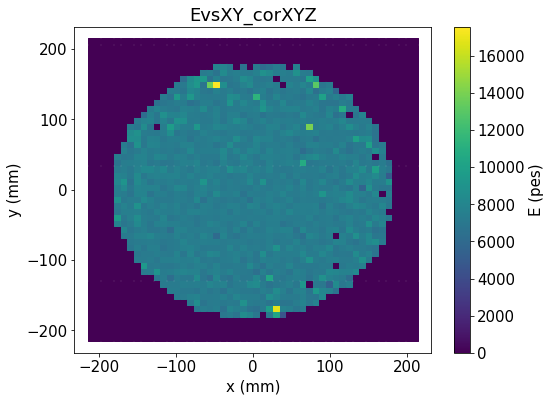

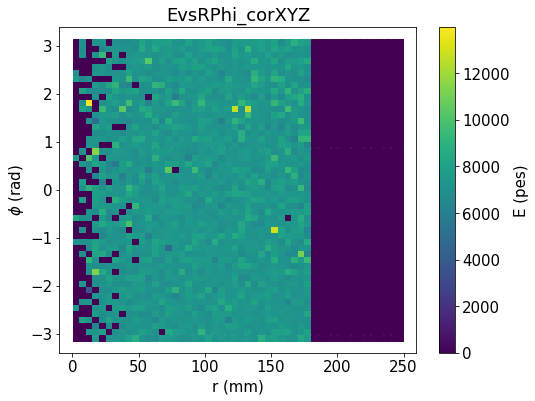

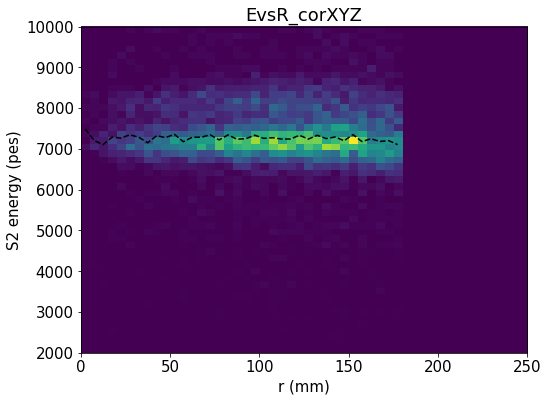

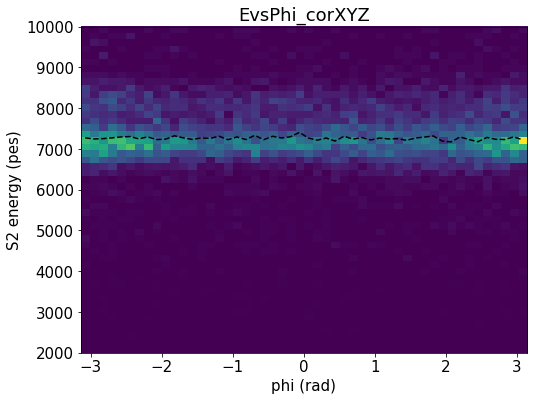

In [253]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 250
prange = - pi,  pi
Erange =  2e3, 10e3


data = filt_XR[(filt_XR.Z<150)&(filt_XR.R<180)][:]

Ez  = data.S2e * zcorr(data.Z) * xycorr(data.X.values, data.Y.values)


#filt_XR[filt_XR.Z<150].X[:], filt_XR[filt_XR.Z<150].Y[:]

pf, _, cb = profile_and_scatter(data.X, data.Y, Ez, (50, 50), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
save("EvsXY_corXYZ")

_, _, cb = profile_and_scatter(data.R, data.Phi, Ez, (50, 50), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("EvsRPhi_corXYZ")

hist2d(data.R, Ez, (50, 50), range=(rrange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data.R, Ez, 50, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
save("EvsR_corXYZ")

hist2d(data.Phi, Ez, (50, 50), range=(prange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data.Phi, Ez, 50, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi_corXYZ")



[  9.43090994e+05   7.12038008e+03   2.74214956e+02   2.55881623e+05
   8.01937817e+03   3.21610528e+02   3.87583598e+01] 
 [  4.37304169e+04   1.12589294e+01   1.05390133e+01   6.01549627e+04
   4.93716140e+01   6.02500726e+01   3.25927775e+01]
res 0.0906940660449 0.0100195579385


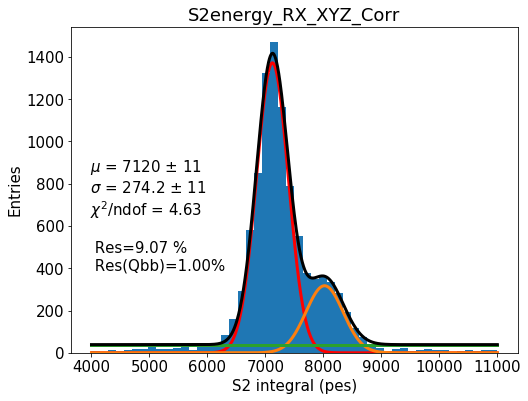

In [259]:
data = filt_XR[(filt_XR.Z<150)&(filt_XR.R<180)][:]

Ez_  = data.S2e * zcorr(data.Z) * xycorr(data.X.values, data.Y.values)

entries, xbins, _ = hist(Ez_, 50, range=(4e3, 11e3))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 6.5e3, 9e3)


f = fitf.fit(fun, xbins[selbins], entries[selbins],( 10e4, 7000, 500, 9e4, 8050, 500, 0),
                                            bounds=([8e4, 6000, 100, 1e4, 7000, 100, 0],
                                                    [10e6, 8000, 1000,15e5, 10000, 2000, 100] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values,"\n",f.errors)
print('res',res,(30/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("$\mu$ $\sigma$".split(),
                                            f.values[1:],
                                            f.errors[1:])] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (29.6/2458)**0.5*res*100)

xrange = np.linspace(4e3, 11e3,1000)

plt.text(min(xbins)-100, 400, text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=3)
plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]), linewidth=3)
plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=3)
plt.plot(xrange, f.fn(xrange), "k-", linewidth=3)


labels("S2 integral (pes)", "Entries")
save("S2energy_RX_XYZ_Corr")

[  3.74125719e+05   7.12761286e+03   2.48524153e+02   1.01990451e+05
   8.07261268e+03   2.88418362e+02   1.08945636e+01] 
 [  1.67496342e+04   8.01485495e+00   8.92532995e+00   2.09451803e+04
   3.54916661e+01   4.63053823e+01   1.36626975e+01]
res 0.0821136603148 0.00907162522251


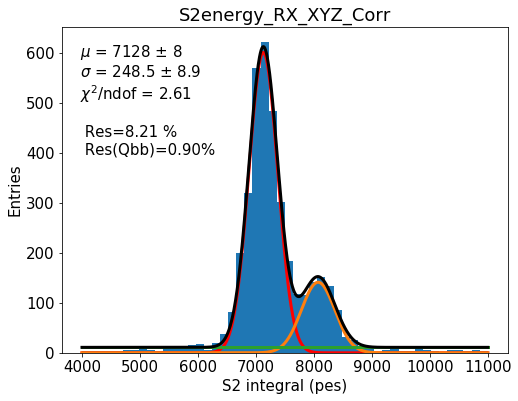

In [529]:
data = filt_XR[(filt_XR.Z<150)&(filt_XR.R<100)][:]

Ez_  = data.S2e * zcorr(data.Z) * xycorr(data.X.values, data.Y.values)

entries, xbins, _ = hist(Ez_, 50, range=(4e3, 11e3))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 6.5e3, 9e3)


f = fitf.fit(fun, xbins[selbins], entries[selbins],( 10e4, 7000, 500, 9e4, 8050, 500, 0),
                                            bounds=([8e4, 6000, 100, 1e4, 7000, 100, 0],
                                                    [10e6, 8000, 1000,15e5, 10000, 2000, 100] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values,"\n",f.errors)
print('res',res,(30/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("$\mu$ $\sigma$".split(),
                                            f.values[1:],
                                            f.errors[1:])] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (29.6/2458)**0.5*res*100)

xrange = np.linspace(4e3, 11e3,1000)

plt.text(min(xbins)-100, 400, text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=3)
plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]), linewidth=3)
plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=3)
plt.plot(xrange, f.fn(xrange), "k-", linewidth=3)


labels("S2 integral (pes)", "Entries")
save("S2energy_RX_XYZ_Corr")

In [381]:
3.74125719e5/(xbins[1]-xbins[0])

2672.3265642857141

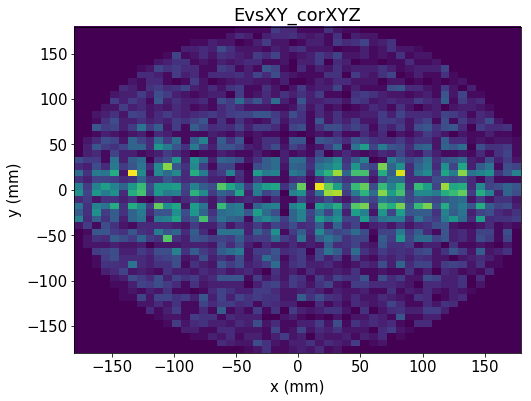

In [309]:
data = filt_XR[(filt_XR.Z>175)&(filt_XR.R<180)][:]
hist2d(data.X, data.Y, [50, 50])
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
save("EvsXY_corXYZ")

# Time correction

[  6.92501390e+03   9.24629095e-04]


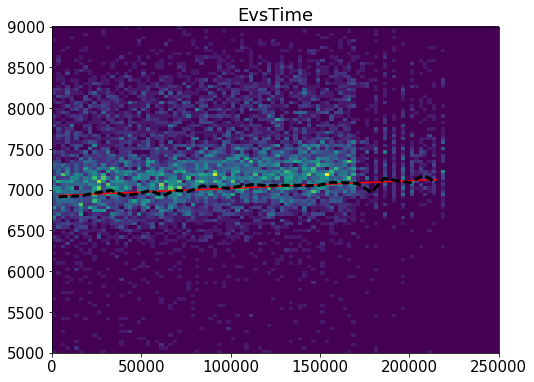

In [520]:
data =filt_XR[(filt_XR.Z<150)&(filt_XR.R<180)]

Et = data.S2e * zcorr(data.Z) * xycorr(data.X.values, data.Y.values)

time = data.time
time = time-np.min(time)
hist2d(time,Et,[100,100], range=[[0,25e4],[5000,9000]]);
x, y, _ = fitf.profileX(time,Et, 30, yrange=[5000,7500])

f = fitf.fit(fitf.polynom, x, y, (6000,-200))
plt.plot(x, f.fn(x), fitOpt)
print(f.values)

plt.plot(x, y, profOpt, linewidth=3)

tfun  = f.fn
tmin  = np.min(x)
tcorr = lambda t: tfun(tmin)/tfun(t)

save("EvsTime")

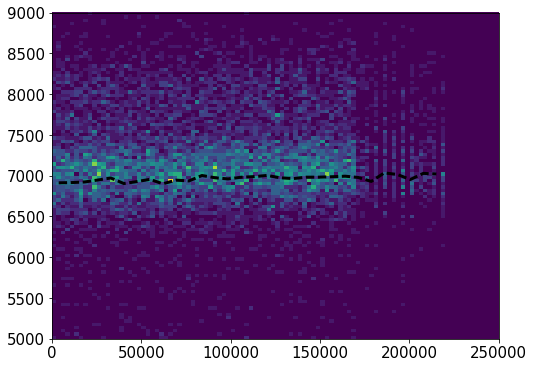

In [521]:
data =filt_XR[(filt_XR.Z<150)&(filt_XR.R<180)]

time = data.time
time = time-np.min(time)

Et = data.S2e * zcorr(data.Z) * xycorr(data.X.values, data.Y.values) * tcorr(time)

hist2d(time, Et,[100,100], range=[[0,25e4],[5000,9000]]);
x, y, _ = fitf.profileX(time, Et, 30, yrange=[5000,7500])
plt.plot(x, y, profOpt, linewidth=3)

[  1.91430706e+05   7.04423633e+03   2.41836969e+02   5.42850836e+04
   7.98888716e+03   2.79622235e+02   2.24071656e+00] 
 [  5.80859239e+03   5.22658409e+00   5.92472892e+00   7.39865538e+03
   2.22877811e+01   2.97027284e+01   4.92291617e+00]
res 0.0808499367361 0.00893201353492


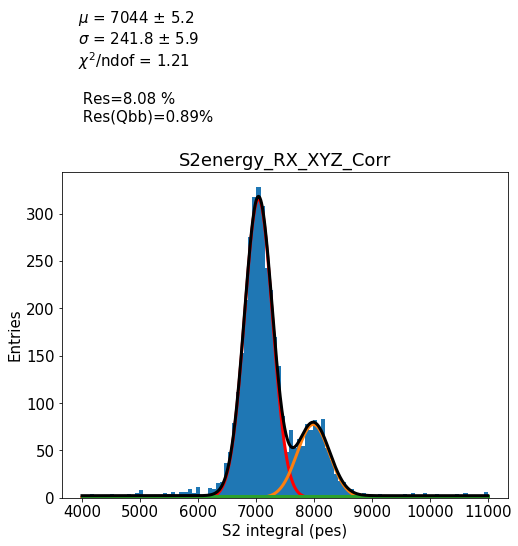

In [526]:
data = filt_XR[(filt_XR.Z<150)&(filt_XR.R<100)][:]

Ez_  = data.S2e * zcorr(data.Z) * xycorr(data.X.values, data.Y.values) * tcorr(data.time-np.min(data.time))

entries, xbins, _ = hist(Ez_, 100, range=(4e3, 11e3))
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 6.5e3, 9e3)


f = fitf.fit(fun, xbins[selbins], entries[selbins],( 10e4, 7000, 500, 9e4, 8050, 500, 0),
                                            bounds=([8e4, 6000, 100, 1e4, 7000, 100, 0],
                                                    [10e6, 8000, 1000,15e5, 10000, 2000, 100] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values,"\n",f.errors)
print('res',res,(30/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("$\mu$ $\sigma$".split(),
                                            f.values[1:],
                                            f.errors[1:])] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (29.6/2458)**0.5*res*100)

xrange = np.linspace(4e3, 11e3,1000)

plt.text(min(xbins)-100, 400, text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=3)
plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]), linewidth=3)
plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=3)
plt.plot(xrange, f.fn(xrange), "k-", linewidth=3)


labels("S2 integral (pes)", "Entries")
save("S2energy_RX_XYZ_Corr")

# Full range results

In [407]:
full = data_read[:]

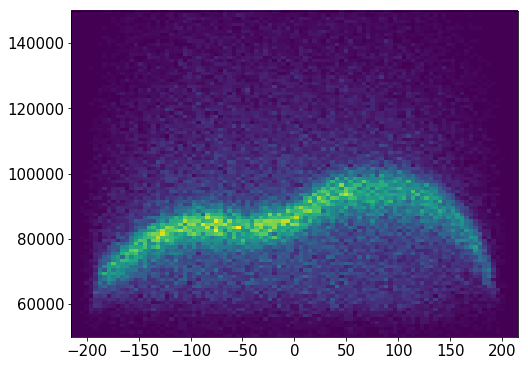

In [408]:
data = full[(full.S1e>100)& (full.S1e<150)]

hist2d(data.X, data.S2e,[100,100],[[-215,215],[50e3,150e3]]);

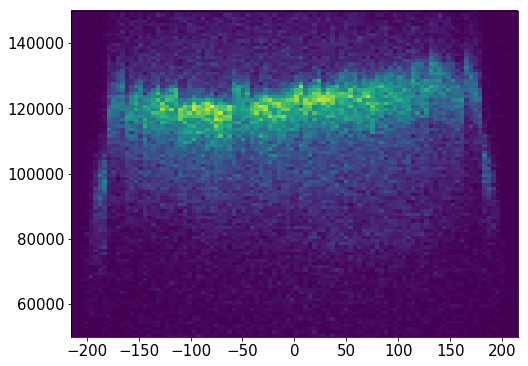

In [414]:
data = full[(full.S1e>100)& (full.S1e<150)]

E =  data.S2e * zcorr(data.Z) * xycorr(data.X.values, data.Y.values)

hist2d(data.X,E,[100,100],[[-215,215],[50e3,150e3]]);

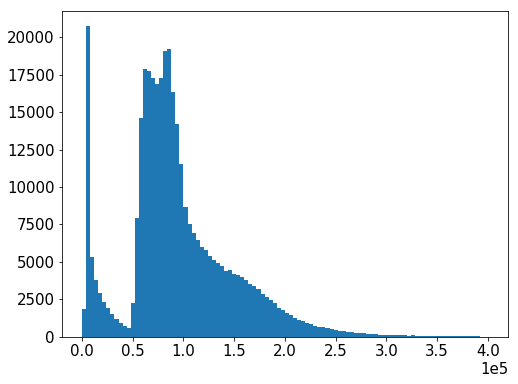

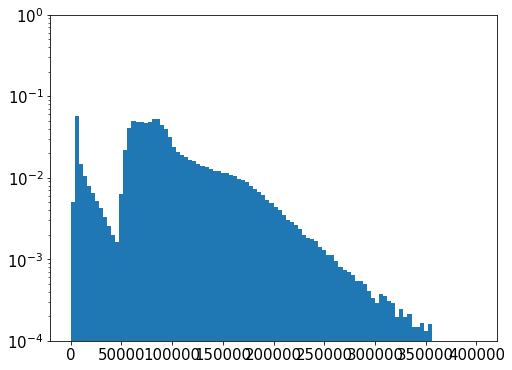

In [385]:
entries, xbins, _ = hist(full.S2e, 100, range=(0,4e5))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
Fuya = pdf(full.S2e, 100, range=(0,4e5))

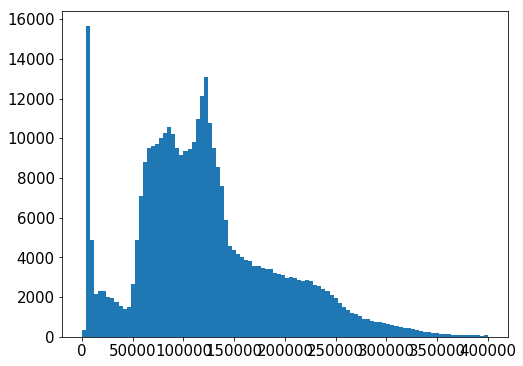

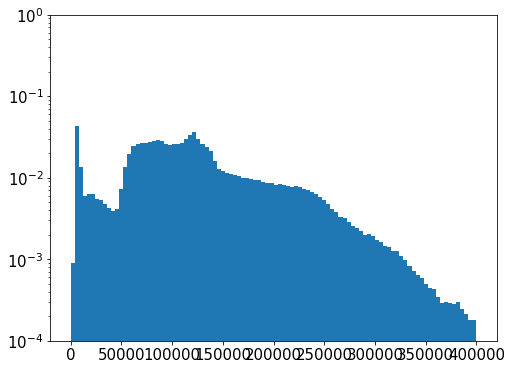

In [36]:
fullE = full.S2e
fullE = fullE * zcorr(full.Z)

entries, xbins, _ = hist(fullE, 100, range=(0,4e5))
a = pdf(fullE, 100, range=(0,4e5))

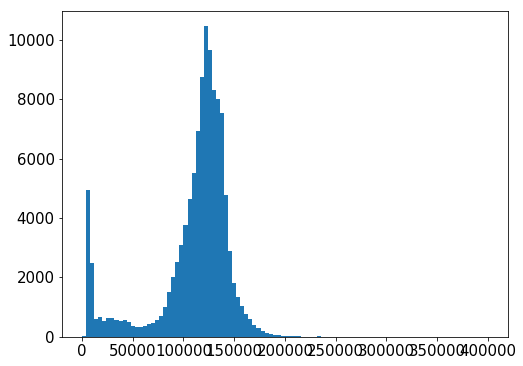

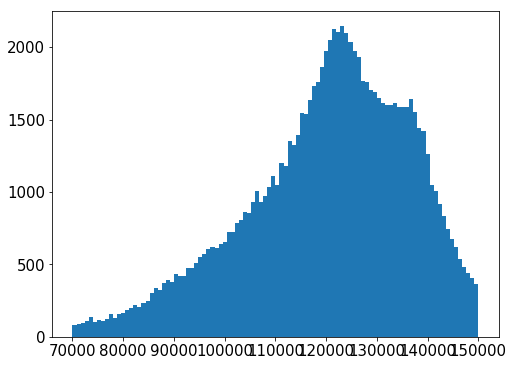

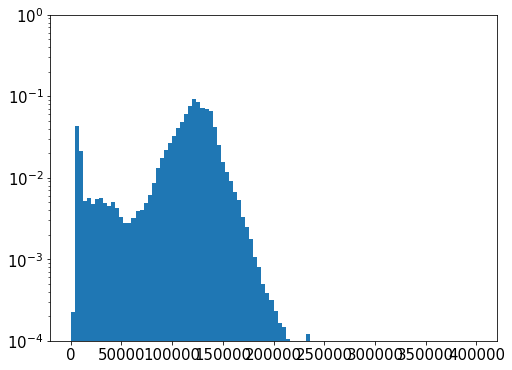

In [67]:
r_fullE = fullE[(full.S1e>100)& (full.S1e<150)] * rcorr(full.R[(full.S1e>100)& (full.S1e<150)])

entries, xbins, _ = hist(r_fullE, 100, range=(0,4e5))

entries, xbins, _ = hist(r_fullE, 100, range=(7e4,1.5e5))
a = pdf(r_fullE, 100, range=(0,4e5))

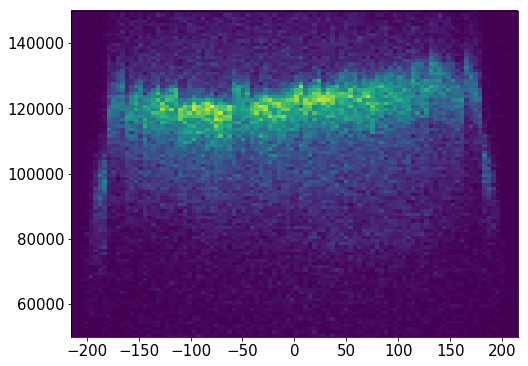

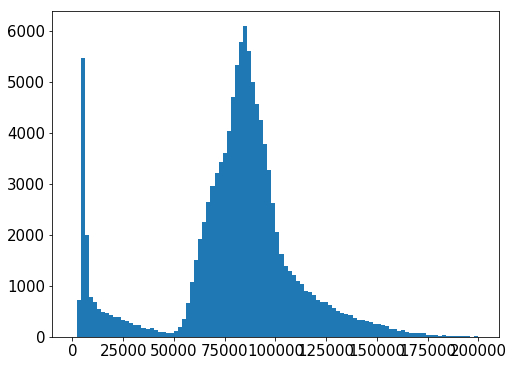

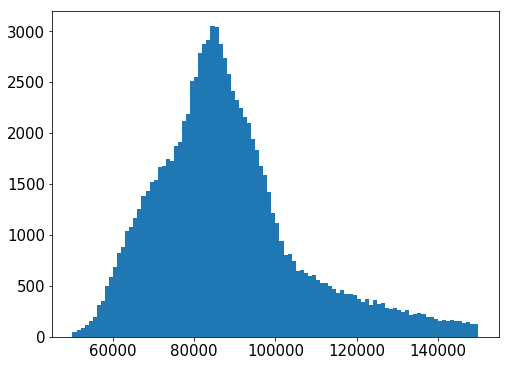

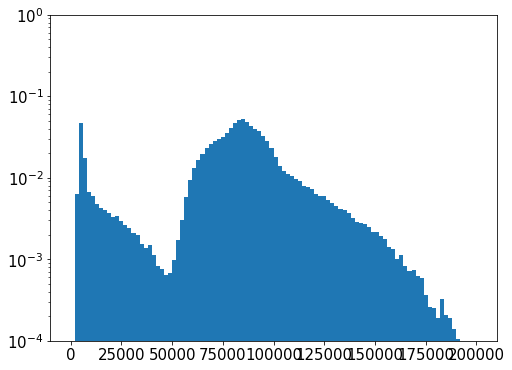

In [38]:
r_fullE = fullE * rcorr(full.R)

entries, xbins, _ = hist(full[(full.S1e>100)& (full.S1e<150)].S2e, 100, range=(0,2e5))

entries, xbins, _ = hist(full[(full.S1e>100)& (full.S1e<150)].S2e, 100, range=(5e4,1.5e5))
a = pdf(full[(full.S1e>100)& (full.S1e<150)].S2e, 100, range=(0,2e5))

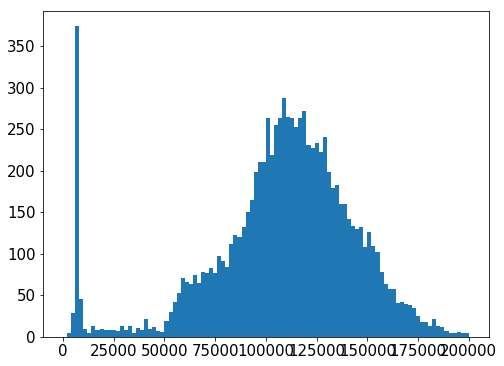

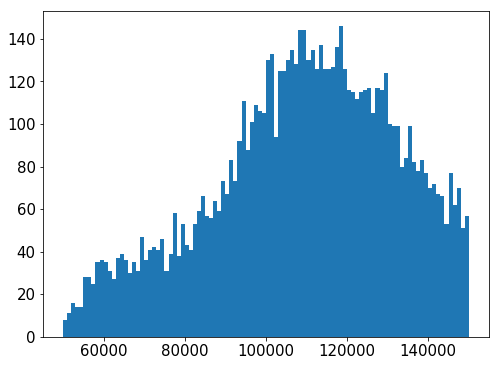

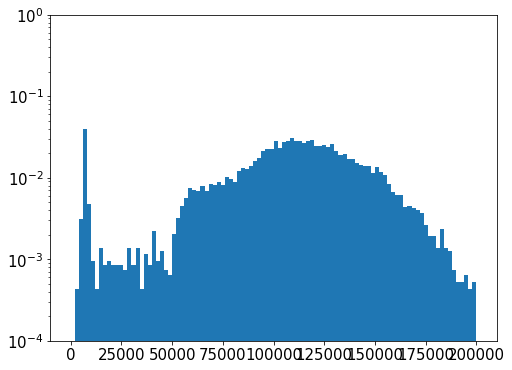

In [39]:
r_fullE_c = full[(full.R<100)&(full.S1e>100)& (full.S1e<150)&(full.Z<100)].S2e

entries, xbins, _ = hist(r_fullE_c, 100, range=(0,2e5))

entries, xbins, _ = hist(r_fullE_c, 100, range=(5e4,1.5e5))
a = pdf(r_fullE_c, 100, range=(0,2e5))

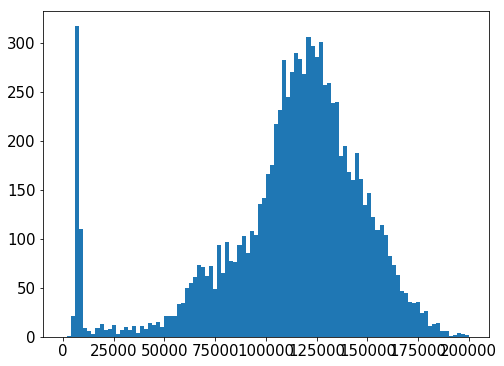

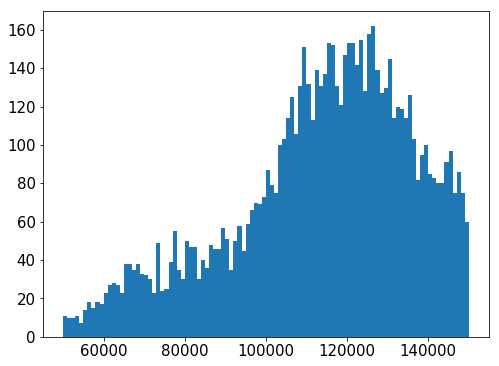

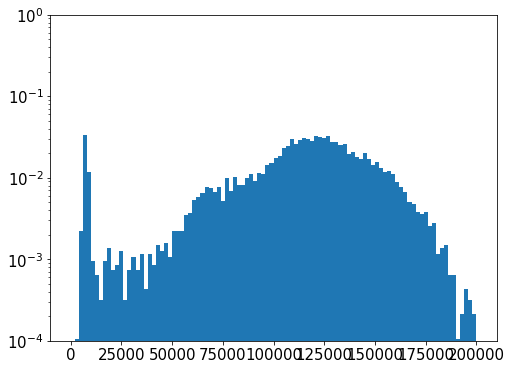

In [40]:
r_fullE_c = r_fullE[(full.R<100)&(full.S1e>100)& (full.S1e<150)&(full.Z<100)]

entries, xbins, _ = hist(r_fullE_c, 100, range=(0,2e5))

entries, xbins, _ = hist(r_fullE_c, 100, range=(5e4,1.5e5))
a = pdf(r_fullE_c, 100, range=(0,2e5))


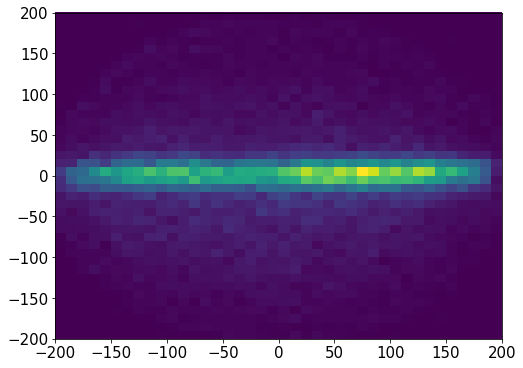

In [96]:
a = hist2d(full[(full.S1e>100)& (full.S1e<150)&(full.Z>175)].X, 
                        full[(full.S1e>100)& (full.S1e<150)&(full.Z>175)].Y,                        
                        [40,40], range=([[-200,200],[-200,200]]));

21
[  2.19748094e+06   1.24355887e+05   5.04026164e+03   1.09304253e+01] 
 [  1.10851434e+05   1.85503976e+02   2.30408639e+02   3.02176027e+00]
res 0.0954503761683 0.0435208285701


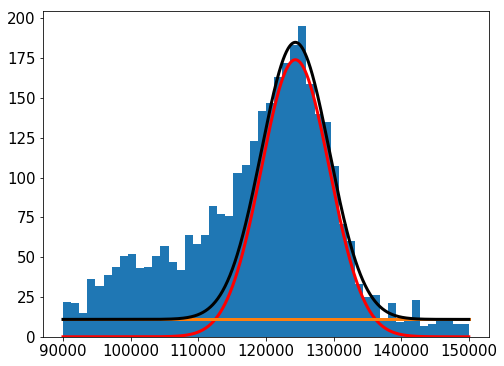

In [383]:
data = full[(full.S1e>100)& (full.S1e<150)&(full.Z>175)&(full.X<100)&(full.X>50)&(full.nS2==1)]

E =  data.S2e * zcorr(data.Z) * xycorr(data.X.values, data.Y.values)


entries, xbins, _ = hist(E,50,[90e3,150e3]);
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins, 120e3,145e3)
print(xbins[selbins].size)

func = lambda x, *args: fitf.gauss(x, *args[:3]) + args[-1] 
f = fitf.fit(func, xbins[selbins], entries[selbins],(10e4, 95e3, 100e3, 20))#,
                                            #bounds=([8e4, 6000, 100, 1e4, 7000, 100, 0],
                                            #        [10e6, 8000, 1000,15e5, 10000, 2000, 100] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values,"\n",f.errors)
print('res',res,(511/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("$\mu$ $\sigma$".split(),
                                            f.values[1:],
                                            f.errors[1:])] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (511/2458)**0.5*res*100)

xrange = np.linspace(90e3,150e3,1000)

#plt.text(min(xbins)-100, 400, text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=3)
#plt.plot(xrange, fitf.expo(xrange, *f.values[3:-1]), linewidth=3)
plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=3)
plt.plot(xrange, f.fn(xrange), "k-", linewidth=3)


In [384]:
2.19748094e6/(xbins[1]-xbins[0])

1831.2341166666665

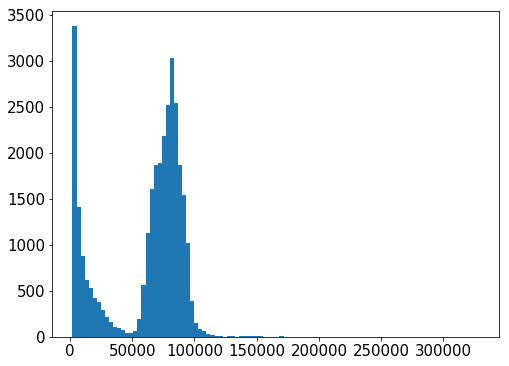

In [313]:
a = hist(full[(full.S1e>100)& (full.S1e<150)&(full.Z>175)].S2e,100);

jijijiji 2053913.73771
2053913.73771


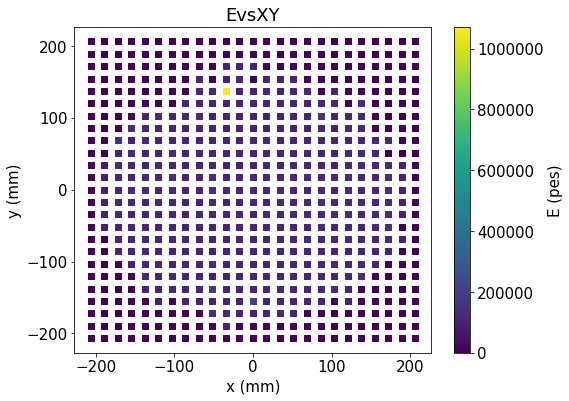

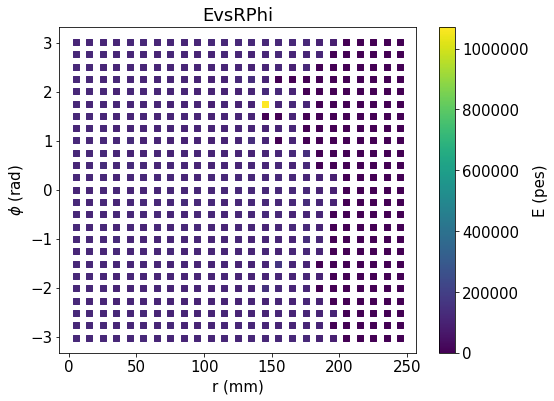

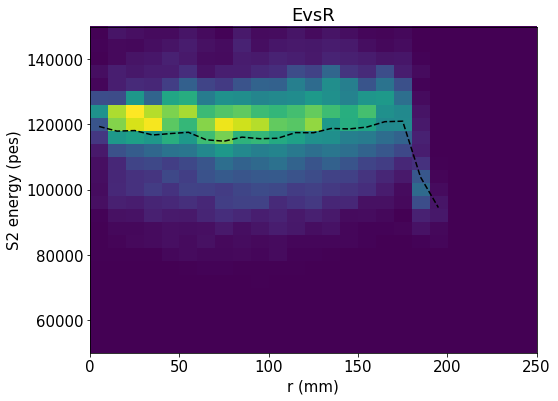

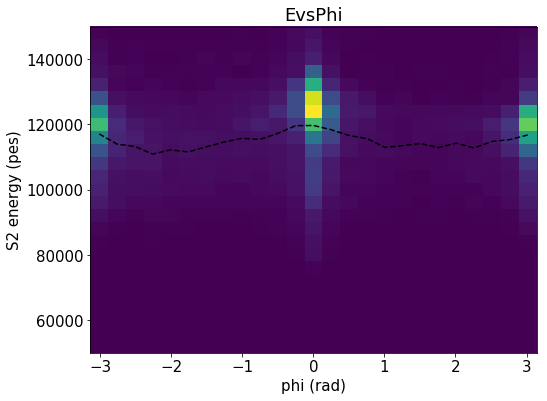

In [447]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 250
prange = - pi,  pi
Erange =  50e3, 150e3
nbin = 25

#data = filt_XR[filt_XR.Z<150][:]
data = full[(full.S1e>100)& (full.S1e<150)&(full.Z>175)&(full.nS2==1)]

Ez =  data.S2e * zcorr(data.Z) * xycorr(data.X.values, data.Y.values)


pf, _, cb = profile_and_scatter(data.X, data.Y, Ez, (nbin, nbin), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
save("EvsXY")

_, _, cb = profile_and_scatter(data.R, data.Phi, Ez, (nbin, nbin), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("EvsRPhi")

hist2d(data.R, Ez, (nbin, nbin), range=(rrange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data.R, Ez, nbin, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
save("EvsR")

hist2d(data.Phi, Ez, (nbin, nbin), range=(prange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data.Phi, Ez, nbin, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi")

print('jijijiji',np.nanmax(Ez.values))

xycorr_PP = get_xycorr_PP(*pf[:-1], eref=np.nanmax(Ez.values))

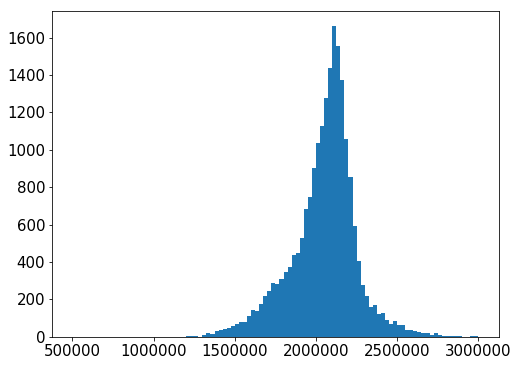

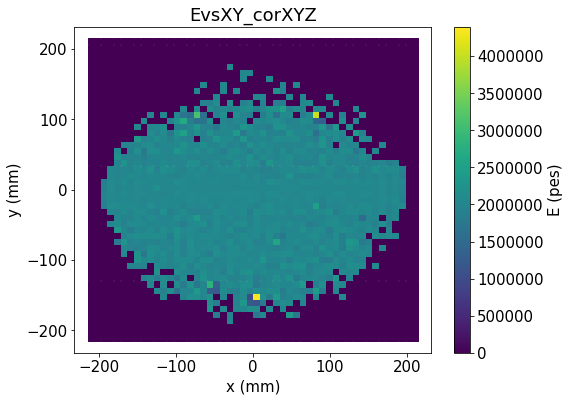

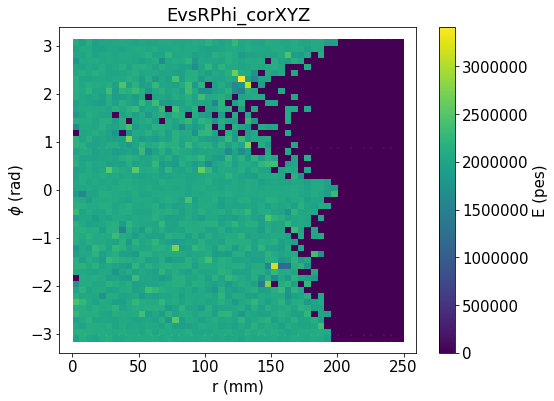

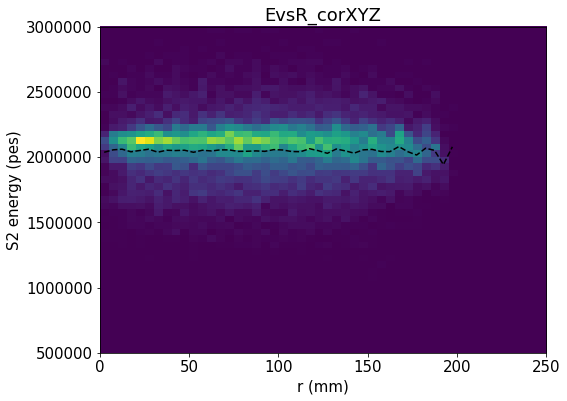

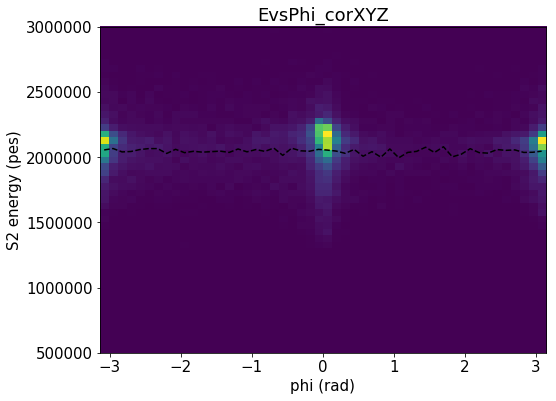

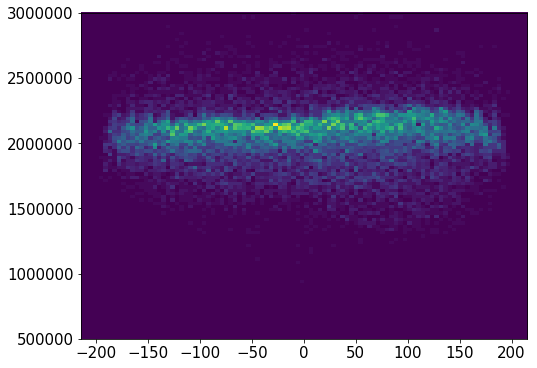

In [449]:
xrange = -215, 215
yrange = -215, 215
rrange =    0, 250
prange = - pi,  pi
Erange =  500e3,3e6


data = full[(full.S1e>100)& (full.S1e<150)&(full.Z>175)&(full.nS2==1)]

Ez  = data.S2e * zcorr(data.Z) * xycorr(data.X.values, data.Y.values) * xycorr_PP(data.X.values, data.Y.values)



hist(Ez,100,Erange);

#filt_XR[filt_XR.Z<150].X[:], filt_XR[filt_XR.Z<150].Y[:]

pf, _, cb = profile_and_scatter(data.X, data.Y, Ez, (50, 50), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
save("EvsXY_corXYZ")

_, _, cb = profile_and_scatter(data.R, data.Phi, Ez, (50, 50), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("EvsRPhi_corXYZ")

hist2d(data.R, Ez, (50, 50), range=(rrange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data.R, Ez, 50, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
save("EvsR_corXYZ")

hist2d(data.Phi, Ez, (50, 50), range=(prange, Erange), weights=Ez)
x, y, _ = fitf.profileX(data.Phi, Ez, 50, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi_corXYZ")


hist2d(data.X,Ez,[100,100],range=(xrange,Erange));



23
[  2.39791537e+08   2.11636151e+06   8.05808833e+04   8.99162284e+01] 
 [  7.43140338e+06   1.93262202e+03   2.37129047e+03   1.23255737e+01]
res 0.0896670907966 0.0408839256962


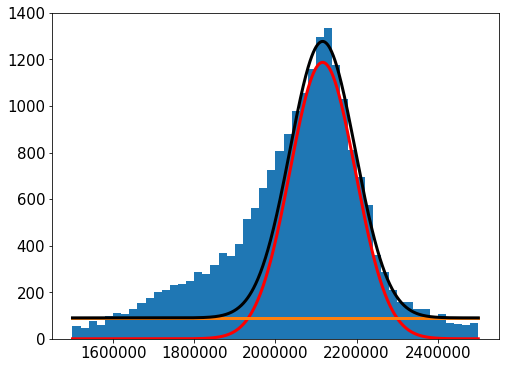

In [464]:
Erange =  1.5e6,2.5e6


data = full[(full.S1e>100)& (full.S1e<150)&(full.Z>175)&(full.nS2==1)]

E  = data.S2e * zcorr(data.Z) * xycorr(data.X.values, data.Y.values) * xycorr_PP(data.X.values, data.Y.values)


entries, xbins, _ = hist(E,50,Erange);
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins,2.05e6,Erange[1])
print(xbins[selbins].size)

func = lambda x, *args: fitf.gauss(x, *args[:3]) + args[-1] 
f = fitf.fit(func, xbins[selbins], entries[selbins],(10e4, 2.0e6, 1e6, 20))#,
                                            #bounds=([8e4, 6000, 100, 1e4, 7000, 100, 0],
                                            #        [10e6, 8000, 1000,15e5, 10000, 2000, 100] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values,"\n",f.errors)
print('res',res,(511/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("$\mu$ $\sigma$".split(),
                                            f.values[1:],
                                            f.errors[1:])] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (511/2458)**0.5*res*100)

xrange = np.linspace(Erange[0],Erange[1],1000)

#plt.text(min(xbins)-100, 400, text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=3)
#plt.plot(xrange, fitf.expo(xrange, *f.values[3:-1]), linewidth=3)
plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=3)
plt.plot(xrange, f.fn(xrange), "k-", linewidth=3)

20
[  3.57894052e+07   2.15513103e+06   7.97705841e+04   1.17242223e+01] 
 [  3.85048623e+06   7.04266893e+03   7.83792319e+03   5.65130546e+00]
res 0.0871685863114 0.0397447265673


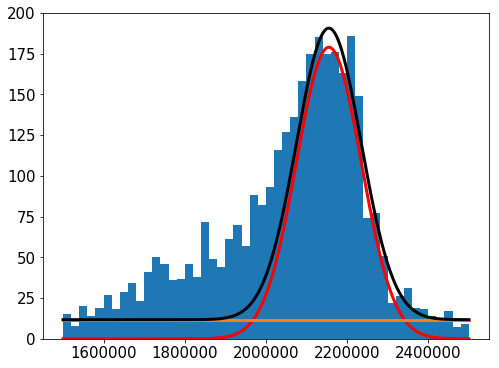

In [466]:
Erange =  1.5e6,2.5e6


data = full[(full.S1e>100)& (full.S1e<150)&(full.Z>175)&(full.nS2==1)&(full.X<100)&(full.X>50)]

E  = data.S2e * zcorr(data.Z) * xycorr(data.X.values, data.Y.values) * xycorr_PP(data.X.values, data.Y.values)


entries, xbins, _ = hist(E,50,Erange);
xbins    = get_centers(xbins)
selbins  = fitf.in_range(xbins,2.1e6,Erange[1])
print(xbins[selbins].size)

func = lambda x, *args: fitf.gauss(x, *args[:3]) + args[-1] 
f = fitf.fit(func, xbins[selbins], entries[selbins],(10e4, 2.0e6, 1e6, 20))#,
                                            #bounds=([8e4, 6000, 100, 1e4, 7000, 100, 0],
                                            #        [10e6, 8000, 1000,15e5, 10000, 2000, 100] ))
mean, sigma = f.values[1], f.values[2]
res = 2.355*sigma/mean
print(f.values,"\n",f.errors)
print('res',res,(511/2458)**0.5*res)

text = "\n".join(["{} = {:.4g} $\pm$ {:.2g}".format(name, val, err)
                  for name, val, err in zip("$\mu$ $\sigma$".split(),
                                            f.values[1:],
                                            f.errors[1:])] + 
                 ["$\chi^2$/ndof = {:.2f}".format(f.chi2)])
text += "\n\n Res={:.2f} % \n Res(Qbb)={:.2f}% ".format(res*100, (511/2458)**0.5*res*100)

xrange = np.linspace(Erange[0],Erange[1],1000)

#plt.text(min(xbins)-100, 400, text, fontsize=15);
plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=3)
#plt.plot(xrange, fitf.expo(xrange, *f.values[3:-1]), linewidth=3)
plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=3)
plt.plot(xrange, f.fn(xrange), "k-", linewidth=3)